# Initial Steps

## Importing Libraries

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("heart_2020_cleaned.csv")

# Modelling

In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score

<a id="29"></a>

<font color='DeepSkyBlue'>


## PREPROCESSING

In [ ]:
df_copy = df.copy()

In [ ]:
df["id"]=range(1,319796)
df=df.set_index("id")

In [ ]:
df_cat=df.select_dtypes(include=["object"])

In [ ]:
df_categorical=df_cat.columns
df_categorical

In [ ]:
for var in df_categorical:
    Dummy=pd.get_dummies(df[var], drop_first= True).add_prefix(var)
    df=df.merge(Dummy,on="id")
    df=df.drop([var],axis=1)

In [ ]:
df.columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler=MinMaxScaler()
columns=df.columns
s=scaler.fit_transform(df)

df=pd.DataFrame(s,columns=columns)
df.head(5)

In [ ]:
df.columns

In [ ]:
stratified_sample = df.groupby('HeartDiseaseYes', group_keys=False).apply(lambda x: x.sample(7500))

X_test = stratified_sample.drop("HeartDiseaseYes", axis=1)
y_test= stratified_sample.HeartDiseaseYes

In [ ]:
df_stratified = pd.concat((X_test,y_test), axis=1)
df_stratified["HeartDiseaseYes"].value_counts()

In [ ]:
df_all = df.merge(df_stratified.drop_duplicates(), on= ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'SmokingYes',
       'AlcoholDrinkingYes', 'StrokeYes', 'DiffWalkingYes', 'SexMale',
       'AgeCategory25-29', 'AgeCategory30-34', 'AgeCategory35-39',
       'AgeCategory40-44', 'AgeCategory45-49', 'AgeCategory50-54',
       'AgeCategory55-59', 'AgeCategory60-64', 'AgeCategory65-69',
       'AgeCategory70-74', 'AgeCategory75-79', 'AgeCategory80 or older',
       'RaceAsian', 'RaceBlack', 'RaceHispanic', 'RaceOther', 'RaceWhite',
       'DiabeticNo, borderline diabetes', 'DiabeticYes',
       'DiabeticYes (during pregnancy)', 'PhysicalActivityYes',
       'GenHealthFair', 'GenHealthGood', 'GenHealthPoor', 'GenHealthVery good',
       'AsthmaYes', 'KidneyDiseaseYes', 'SkinCancerYes', 'HeartDiseaseYes'], how="left", indicator='True')

train_dataset = df_all[df_all['True'] == 'left_only']

X_train = train_dataset.drop(["HeartDiseaseYes", "True"], axis=1)
y_train = train_dataset.HeartDiseaseYes

In [ ]:
print(y_train.value_counts())
y_test.value_counts()

In [ ]:
classweight = {0: 1, 1: 14}

models=[LogisticRegression(class_weight=classweight), GaussianNB()]
scores=dict()

performance_table = ['Model', 'Accuracy', 'Precision', 'Percentage_mislabbled'
                    'Total_Ones', 'Mislabble_Ones', 'Percent_Mislabbled_Ones', 'Recall_Score', 'F1_Score']

Model = []
Accuracy = []
Precision = []
Percentage_mislabbled = []
Percent_Mislabbled_zeroes =[]
Percent_Mislabbled_Ones =[]
Recall_Score =[]
F1_Score = []


for m in models:
    m.fit(X_train,y_train)
    y_pred=m.predict(X_test)
    percent_mislabbled = (((y_test != y_pred).sum())/X_test.shape[0])*100
    

    y_pred_df = pd.DataFrame(np.array(y_pred), columns= ['ypred'])
    y_test_df = pd.DataFrame(y_test.values, columns = ['y_test'])
    df_test = pd.concat([y_pred_df, y_test_df], axis=1)
    df_test1 = df_test[df_test['y_test'] == 1]
    df_test0 = df_test[df_test['y_test'] == 0]
    percent_how_many_ones_mislabbled = ((df_test1.y_test != df_test1.ypred).sum()) / (len(df_test[df_test['y_test'] == 1])) * 100
    percent_how_many_zeroes_mislabbled = ((df_test0.y_test != df_test0.ypred).sum()) / (len(df_test[df_test['y_test'] == 0])) * 100
    
    

    Model.append(m)    
    Accuracy.append(accuracy_score(y_test,y_pred))
    Precision.append(precision_score(y_test,y_pred))
    Percentage_mislabbled.append(percent_mislabbled)
    Percent_Mislabbled_zeroes.append(percent_how_many_zeroes_mislabbled)    
    Percent_Mislabbled_Ones.append(percent_how_many_ones_mislabbled)
    Recall_Score.append(recall_score(y_test,y_pred))
    F1_Score.append(f1_score(y_test,y_pred))

performance_table = {'Model':Model , 'Accuracy':Accuracy, 'Precision': Precision, 'Percentage_mislabbled':Percentage_mislabbled, 'Percent_Mislabbled_zeroes': Percent_Mislabbled_zeroes,
                                            'Percent_Mislabbled_Ones': Percent_Mislabbled_Ones , 'Recall_Score': Recall_Score, 
                                            'F1_Score' :F1_Score}

performance_table_clswht = pd.DataFrame(performance_table)
performance_table_clswht

In [ ]:
logreg = LogisticRegression(class_weight = {0: 1, 1: 14})
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test, y_pred_logreg)

plt.plot(fpr, tpr)
plt.plot([1,0], [1, 0])
plt.xlabel('FPR (1-Specificity)')
plt.ylabel('Tpr (sensitivity')
plt.title('Roc Auc Curve')
plt.legend()
plt.show()


In [ ]:
youdens_table = pd.DataFrame({'TPR': tpr,'FPR': fpr,'Threshold': threshold})

youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)
youdens_table.head()


In [ ]:
from sklearn.metrics import *

In [ ]:
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob = pd.DataFrame(y_pred_prob)
y_pred_prob

In [ ]:
score_card = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])

# append the result table for all performance scores
# performance measures considered for model comparision are 'AUC Score', 'Precision Score', 'Recall Score','Accuracy Score',
# 'Kappa Score', and 'f1-score'
# compile the required information in a user defined function 
def update_score_card(model, cutoff):
    
    # let 'y_pred_prob' be the predicted values of y
    
    y_pred_prob = logreg.predict_proba(X_test)
    y_pred_prob = pd.DataFrame(y_pred_prob)[1]

    # convert probabilities to 0 and 1 using 'if_else'
    y_pred = [ 0 if x < cutoff else 1 for x in y_pred_prob]
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Probability Cutoff': cutoff,
                                    'AUC Score' : roc_auc_score(y_test, y_pred),
                                    'Precision Score': precision_score(y_test, y_pred),
                                    'Recall Score': recall_score(y_test, y_pred),
                                    'Accuracy Score': accuracy_score(y_test, y_pred),
                                    'Kappa Score':cohen_kappa_score(y_test, y_pred),
                                    'f1-score': f1_score(y_test, y_pred)}, 
                                    ignore_index = True)

In [ ]:
cutoff = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for value in cutoff:
    update_score_card(logreg, value)
print('Score Card for Logistic regression:')

score_card = score_card.sort_values('Probability Cutoff').reset_index(drop = True)

score_card.style.highlight_max(color = 'lightblue', subset = ['AUC Score', 'Accuracy Score', 'Kappa Score', 'f1-score'])

# Variable Modifications

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
len(X_train.columns)

In [ ]:
X_train_rfe = X_train
X_test_rfe = X_test

# initiate logistic regression model to use in feature selection
logreg = LogisticRegression()

# build the RFE model
# pass the logistic regression model to 'estimator'
# pass number of required features to 'n_features_to_select'
# if we do not pass the number of features, RFE considers half of the features
rfe_model = RFE(estimator = logreg, n_features_to_select = 25)

# fit the RFE model on the train dataset using fit()
rfe_model = rfe_model.fit(X_train_rfe, y_train)

# create a series containing feature and its corresponding rank obtained from RFE
# 'ranking_' returns the rank of each variable after applying RFE
# pass the ranks as the 'data' of a series
# 'index' assigns feature names as index of a series 
feat_index = pd.Series(data = rfe_model.ranking_, index = X_train_rfe.columns)

# select the features with rank = 1
# 'index' returns the indices of a series (i.e. features with rank=1) 
signi_feat_rfe = feat_index[feat_index==1].index

# print the significant features obtained from RFE
print(signi_feat_rfe)

In [ ]:
X_train.columns

In [ ]:
# BMI, Sleeptime, Age, General Health, Kidney Disease, Asthma, Diabetic, stroke, sex

In [346]:
# 'BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'SmokingYes',
# 'AlcoholDrinkingYes', 'StrokeYes', 'DiffWalkingYes', 'SexMale','AgeCategory'Race 
# 'Diabetic, 'PhysicalActivityYes','GenHealth', 'AsthmaYes', 'KidneyDiseaseYes', 'SkinCancerYes'

# **---------------------**

In [5]:
df_copy = pd.read_csv("heart_2020_cleaned.csv")

In [6]:
df_copy.GenHealth.value_counts()

Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: GenHealth, dtype: int64

In [7]:
dict(df_copy.AgeCategory.value_counts())

{'65-69': 34151,
 '60-64': 33686,
 '70-74': 31065,
 '55-59': 29757,
 '50-54': 25382,
 '80 or older': 24153,
 '45-49': 21791,
 '75-79': 21482,
 '18-24': 21064,
 '40-44': 21006,
 '35-39': 20550,
 '30-34': 18753,
 '25-29': 16955}

In [8]:
df_copy.GenHealth = df_copy.GenHealth.replace(["Poor", "Fair", "Good", "Very good", "Excellent"], [5, 4, 3, 2, 1])

In [9]:
df_copy.GenHealth.value_counts()

2    113858
3     93129
1     66842
4     34677
5     11289
Name: GenHealth, dtype: int64

In [10]:
# df_copy.AgeCategory = df_copy.AgeCategory.replace({'65-69': 9,
#  '60-64': 8,
#  '70-74': 10,
#  '55-59': 7,
#  '50-54': 6,
#  '80 or older': 12,
#  '45-49': 5,
#  '75-79': 11,
#  '18-24': 0,
#  '40-44': 4,
#  '35-39': 3,
#  '30-34': 2,
#  '25-29': 1})

In [11]:
df_copy = df_copy.drop("Race", axis=1)

In [12]:
df_copy.Asthma.value_counts()
df_copy.KidneyDisease.value_counts()
df_copy["SkinCancer"].value_counts()


No     289976
Yes     29819
Name: SkinCancer, dtype: int64

In [13]:
df_copy.Diabetic = df_copy.Diabetic.replace(["No, borderline diabetes", "Yes (during pregnancy)"], ["No", "No"])


In [14]:
df_copy.Diabetic = df_copy.Diabetic.replace(["Yes", "No"], [1, 0])
df_copy.Asthma = df_copy.Asthma.replace(["Yes", "No"], [1, 0])
df_copy.KidneyDisease = df_copy.KidneyDisease.replace(["Yes", "No"], [1, 0])
df_copy.SkinCancer = df_copy.SkinCancer.replace(["Yes", "No"], [1, 0])

In [15]:
print(df_copy.Diabetic.value_counts())
print(df_copy.Asthma.value_counts())
print(df_copy.KidneyDisease.value_counts())
print(df_copy["SkinCancer"].value_counts())

0    278993
1     40802
Name: Diabetic, dtype: int64
0    276923
1     42872
Name: Asthma, dtype: int64
0    308016
1     11779
Name: KidneyDisease, dtype: int64
0    289976
1     29819
Name: SkinCancer, dtype: int64


In [16]:
df_copy['Severity'] = df_copy["Diabetic"] + df_copy['Asthma'] + df_copy['KidneyDisease'] + df_copy["SkinCancer"]

In [17]:
df_copy = df_copy.drop(['Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer'], axis=1)

In [18]:
df = df_copy

In [19]:
df["id"]=range(1,319796)
df=df.set_index("id")

In [20]:
df_cat=df.select_dtypes(include=["object"])

In [21]:
df_categorical=df_cat.columns
df_categorical

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'PhysicalActivity'],
      dtype='object')

In [22]:
for var in df_categorical:
    Dummy=pd.get_dummies(df[var], drop_first= True).add_prefix(var)
    df=df.merge(Dummy,on="id")
    df=df.drop([var],axis=1)

In [23]:
df.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'HeartDiseaseYes', 'SmokingYes', 'AlcoholDrinkingYes',
       'StrokeYes', 'DiffWalkingYes', 'SexMale', 'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler=MinMaxScaler()
columns=df.columns
s=scaler.fit_transform(df)

df=pd.DataFrame(s,columns=columns)
df.head(5)

,BMI,PhysicalHealth,MentalHealth,GenHealth,SleepTime,Severity,HeartDiseaseYes,SmokingYes,AlcoholDrinkingYes,StrokeYes,...,AgeCategory40-44,AgeCategory45-49,AgeCategory50-54,AgeCategory55-59,AgeCategory60-64,AgeCategory65-69,AgeCategory70-74,AgeCategory75-79,AgeCategory80 or older,PhysicalActivityYes
0,0.055294,0.100000,1.0,0.25,0.173913,0.75,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.100447,0.000000,0.0,0.25,0.260870,0.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.175782,0.666667,1.0,0.75,0.304348,0.50,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.147169,0.000000,0.0,0.50,0.217391,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.141132,0.933333,0.0,0.25,0.304348,0.00,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
df.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'HeartDiseaseYes', 'SmokingYes', 'AlcoholDrinkingYes',
       'StrokeYes', 'DiffWalkingYes', 'SexMale', 'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

In [27]:
stratified_sample = df.groupby('HeartDiseaseYes', group_keys=False).apply(lambda x: x.sample(7500))

X_test = stratified_sample.drop("HeartDiseaseYes", axis=1)
y_test= stratified_sample.HeartDiseaseYes

In [28]:
df_stratified = pd.concat((X_test,y_test), axis=1)
df_stratified["HeartDiseaseYes"].value_counts()

0.0    7500
1.0    7500
Name: HeartDiseaseYes, dtype: int64

In [29]:
df.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'HeartDiseaseYes', 'SmokingYes', 'AlcoholDrinkingYes',
       'StrokeYes', 'DiffWalkingYes', 'SexMale', 'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

In [30]:
df_all = df.merge(df_stratified.drop_duplicates(), on= ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'SmokingYes',
       'AlcoholDrinkingYes', 'StrokeYes', 'DiffWalkingYes', 'SexMale',
       'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older','PhysicalActivityYes','GenHealth',
       'Severity', 'HeartDiseaseYes'], how="left", indicator='True')

train_dataset = df_all[df_all['True'] == 'left_only']

X_train = train_dataset.drop(["HeartDiseaseYes", "True"], axis=1)
y_train = train_dataset.HeartDiseaseYes

In [31]:
print(y_train.value_counts())
y_test.value_counts()

0.0    282747
1.0     19797
Name: HeartDiseaseYes, dtype: int64


0.0    7500
1.0    7500
Name: HeartDiseaseYes, dtype: int64

In [32]:
logreg = LogisticRegression(class_weight = {0: 1, 1: 14})
logreg.fit(X_train, y_train)
y_pred_prob = logreg.predict_proba(X_test)
y_pred_prob = list(pd.DataFrame(y_pred_prob)[1])
y_pred = [0 if x < 0.4 else 1 for x in y_pred_prob]

In [36]:
from sklearn.metrics import *

In [37]:
score_card = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])



score_card = score_card.append({'Probability Cutoff': 0.4,
                                'AUC Score' : roc_auc_score(y_test, y_pred),
                                'Precision Score': precision_score(y_test, y_pred),
                                'Recall Score': recall_score(y_test, y_pred),
                                'Accuracy Score': accuracy_score(y_test, y_pred),
                                'Kappa Score':cohen_kappa_score(y_test, y_pred),
                                'f1-score': f1_score(y_test, y_pred)}, 
                                ignore_index = True)
score_card                                

,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,0.4,0.7652,0.71973,0.868667,0.7652,0.5304,0.787216


In [38]:
X_train.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'SmokingYes', 'AlcoholDrinkingYes', 'StrokeYes',
       'DiffWalkingYes', 'SexMale', 'AgeCategory25-29', 'AgeCategory30-34',
       'AgeCategory35-39', 'AgeCategory40-44', 'AgeCategory45-49',
       'AgeCategory50-54', 'AgeCategory55-59', 'AgeCategory60-64',
       'AgeCategory65-69', 'AgeCategory70-74', 'AgeCategory75-79',
       'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


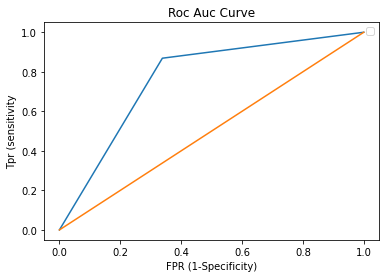

In [40]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.plot([1,0], [1, 0])
plt.xlabel('FPR (1-Specificity)')
plt.ylabel('Tpr (sensitivity')
plt.title('Roc Auc Curve')

plt.legend()
plt.show()


# **---------------------**

In [5]:
df_copy2 = pd.read_csv("heart_2020_cleaned.csv")

In [6]:
df_copy2.GenHealth.value_counts()

Very good    113858
Good          93129
Excellent     66842
Fair          34677
Poor          11289
Name: GenHealth, dtype: int64

In [7]:
dict(df_copy2.AgeCategory.value_counts())

{'65-69': 34151,
 '60-64': 33686,
 '70-74': 31065,
 '55-59': 29757,
 '50-54': 25382,
 '80 or older': 24153,
 '45-49': 21791,
 '75-79': 21482,
 '18-24': 21064,
 '40-44': 21006,
 '35-39': 20550,
 '30-34': 18753,
 '25-29': 16955}

In [8]:
df_copy2.GenHealth = df_copy2.GenHealth.replace(["Poor", "Fair", "Good", "Very good", "Excellent"], [5, 4, 3, 2, 1])

In [9]:
df_copy2.GenHealth.value_counts()

2    113858
3     93129
1     66842
4     34677
5     11289
Name: GenHealth, dtype: int64

In [10]:
# df_copy.AgeCategory = df_copy.AgeCategory.replace({'65-69': 9,
#  '60-64': 8,
#  '70-74': 10,
#  '55-59': 7,
#  '50-54': 6,
#  '80 or older': 12,
#  '45-49': 5,
#  '75-79': 11,
#  '18-24': 0,
#  '40-44': 4,
#  '35-39': 3,
#  '30-34': 2,
#  '25-29': 1})

In [11]:
df_copy2 = df_copy2.drop("Race", axis=1)

In [12]:
df_copy2.Asthma.value_counts()
df_copy2.KidneyDisease.value_counts()
df_copy2["SkinCancer"].value_counts()


No     289976
Yes     29819
Name: SkinCancer, dtype: int64

In [13]:
df_copy2.Diabetic = df_copy2.Diabetic.replace(["No, borderline diabetes", "Yes (during pregnancy)"], ["No", "No"])


In [14]:
df_copy2.Diabetic = df_copy2.Diabetic.replace(["Yes", "No"], [1, 0])
df_copy2.Asthma = df_copy2.Asthma.replace(["Yes", "No"], [1, 0])
df_copy2.KidneyDisease = df_copy2.KidneyDisease.replace(["Yes", "No"], [1, 0])
df_copy2.SkinCancer = df_copy2.SkinCancer.replace(["Yes", "No"], [1, 0])

In [15]:
print(df_copy2.Diabetic.value_counts())
print(df_copy2.Asthma.value_counts())
print(df_copy2.KidneyDisease.value_counts())
print(df_copy2["SkinCancer"].value_counts())

0    278993
1     40802
Name: Diabetic, dtype: int64
0    276923
1     42872
Name: Asthma, dtype: int64
0    308016
1     11779
Name: KidneyDisease, dtype: int64
0    289976
1     29819
Name: SkinCancer, dtype: int64


In [16]:
df_copy2['Severity'] = df_copy2["Diabetic"] + df_copy2['Asthma'] + df_copy2['KidneyDisease'] + df_copy2["SkinCancer"]

In [17]:
df_copy2 = df_copy2.drop(['Diabetic', 'Asthma', 'KidneyDisease', 'SkinCancer'], axis=1)

In [18]:
df = df_copy2

In [19]:
df["id"]=range(1,319796)
df=df.set_index("id")

In [20]:
df_cat=df.select_dtypes(include=["object"])

In [21]:
df_categorical=df_cat.columns
df_categorical

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'PhysicalActivity'],
      dtype='object')

In [22]:
for var in df_categorical:
    Dummy=pd.get_dummies(df[var], drop_first= True).add_prefix(var)
    df=df.merge(Dummy,on="id")
    df=df.drop([var],axis=1)

In [23]:
df.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'HeartDiseaseYes', 'SmokingYes', 'AlcoholDrinkingYes',
       'StrokeYes', 'DiffWalkingYes', 'SexMale', 'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler=MinMaxScaler()
columns=df.columns
s=scaler.fit_transform(df)

df=pd.DataFrame(s,columns=columns)
df.head(5)

,BMI,PhysicalHealth,MentalHealth,GenHealth,SleepTime,Severity,HeartDiseaseYes,SmokingYes,AlcoholDrinkingYes,StrokeYes,...,AgeCategory40-44,AgeCategory45-49,AgeCategory50-54,AgeCategory55-59,AgeCategory60-64,AgeCategory65-69,AgeCategory70-74,AgeCategory75-79,AgeCategory80 or older,PhysicalActivityYes
0,0.055294,0.100000,1.0,0.25,0.173913,0.75,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.100447,0.000000,0.0,0.25,0.260870,0.00,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.175782,0.666667,1.0,0.75,0.304348,0.50,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.147169,0.000000,0.0,0.50,0.217391,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.141132,0.933333,0.0,0.25,0.304348,0.00,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
df.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'HeartDiseaseYes', 'SmokingYes', 'AlcoholDrinkingYes',
       'StrokeYes', 'DiffWalkingYes', 'SexMale', 'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

In [27]:
stratified_sample = df.groupby('HeartDiseaseYes', group_keys=False).apply(lambda x: x.sample(7500))

X_test = stratified_sample.drop("HeartDiseaseYes", axis=1)
y_test= stratified_sample.HeartDiseaseYes

In [28]:
df_stratified = pd.concat((X_test,y_test), axis=1)
df_stratified["HeartDiseaseYes"].value_counts()

0.0    7500
1.0    7500
Name: HeartDiseaseYes, dtype: int64

In [29]:
df.columns

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'GenHealth', 'SleepTime',
       'Severity', 'HeartDiseaseYes', 'SmokingYes', 'AlcoholDrinkingYes',
       'StrokeYes', 'DiffWalkingYes', 'SexMale', 'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older', 'PhysicalActivityYes'],
      dtype='object')

In [30]:
df_all = df.merge(df_stratified.drop_duplicates(), on= ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'SmokingYes',
       'AlcoholDrinkingYes', 'StrokeYes', 'DiffWalkingYes', 'SexMale',
       'AgeCategory25-29',
       'AgeCategory30-34', 'AgeCategory35-39', 'AgeCategory40-44',
       'AgeCategory45-49', 'AgeCategory50-54', 'AgeCategory55-59',
       'AgeCategory60-64', 'AgeCategory65-69', 'AgeCategory70-74',
       'AgeCategory75-79', 'AgeCategory80 or older','PhysicalActivityYes','GenHealth',
       'Severity', 'HeartDiseaseYes'], how="left", indicator='True')

train_dataset = df_all[df_all['True'] == 'left_only']

X_train = train_dataset.drop(["HeartDiseaseYes", "True"], axis=1)
y_train = train_dataset.HeartDiseaseYes

In [31]:
print(y_train.value_counts())
y_test.value_counts()

0.0    282729
1.0     19808
Name: HeartDiseaseYes, dtype: int64


0.0    7500
1.0    7500
Name: HeartDiseaseYes, dtype: int64

In [33]:
from sklearn.metrics import *

In [36]:
from sklearn.ensemble import StackingClassifier
# define dataset
X, y = X_train, y_train
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression(class_weight= {0:1, 1:14})))
level0.append(('bayes', GaussianNB()))
# define meta learner model
level1 = LogisticRegression(class_weight= {0:1, 1:14})
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
y_pred_prob = model.predict_proba(X_test)
y_pred_prob = list(pd.DataFrame(y_pred_prob)[1])
y_pred = [0 if x < 0.4 else 1 for x in y_pred_prob]


score_card = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])



score_card = score_card.append({'Probability Cutoff': 0.4,
                                'AUC Score' : roc_auc_score(y_test, y_pred),
                                'Precision Score': precision_score(y_test, y_pred),
                                'Recall Score': recall_score(y_test, y_pred),
                                'Accuracy Score': accuracy_score(y_test, y_pred),
                                'Kappa Score':cohen_kappa_score(y_test, y_pred),
                                'f1-score': f1_score(y_test, y_pred)}, 
                                ignore_index = True)
score_card  

,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,0.4,0.766933,0.732899,0.84,0.766933,0.533867,0.782803


--------------------

In [37]:
df = pd.read_csv("heart_2020_cleaned.csv")

In [38]:
df["id"]=range(1,319796)
df=df.set_index("id")

In [39]:
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
id,,,,,,,,,,,,,,,,,,
1,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
2,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
3,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
4,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
5,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319791,Yes,27.41,Yes,No,No,7.0,0.0,Yes,Male,60-64,Hispanic,Yes,No,Fair,6.0,Yes,No,No
319792,No,29.84,Yes,No,No,0.0,0.0,No,Male,35-39,Hispanic,No,Yes,Very good,5.0,Yes,No,No
319793,No,24.24,No,No,No,0.0,0.0,No,Female,45-49,Hispanic,No,Yes,Good,6.0,No,No,No


In [40]:
df.GenHealth = df.GenHealth.astype('object')

In [41]:
df_cat=df.select_dtypes(include=["object"])
df_cat

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
id,,,,,,,,,,,,,,
1,No,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
2,No,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
3,No,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
4,No,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
5,No,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319791,Yes,Yes,No,No,Yes,Male,60-64,Hispanic,Yes,No,Fair,Yes,No,No
319792,No,Yes,No,No,No,Male,35-39,Hispanic,No,Yes,Very good,Yes,No,No
319793,No,No,No,No,No,Female,45-49,Hispanic,No,Yes,Good,No,No,No


In [42]:
df_cat=df_cat.columns
df_cat

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [43]:
for var in df_cat:
    Dummy=pd.get_dummies(df[var], drop_first= True).add_prefix(var)
    df=df.merge(Dummy,on="id")
    df=df.drop([var],axis=1)

In [44]:
y=df.HeartDiseaseYes

In [45]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00
HeartDiseaseYes,319795.0,0.085595,0.279766,0.00,0.00,0.00,0.00,1.00
SmokingYes,319795.0,0.412477,0.492281,0.00,0.00,0.00,1.00,1.00
AlcoholDrinkingYes,319795.0,0.068097,0.251912,0.00,0.00,0.00,0.00,1.00
StrokeYes,319795.0,0.037740,0.190567,0.00,0.00,0.00,0.00,1.00
DiffWalkingYes,319795.0,0.138870,0.345812,0.00,0.00,0.00,0.00,1.00
SexMale,319795.0,0.475273,0.499389,0.00,0.00,0.00,1.00,1.00


In [46]:
X=df.drop(["HeartDiseaseYes"],axis=1)
y= df.HeartDiseaseYes

In [47]:
X.head(5)

,BMI,PhysicalHealth,MentalHealth,SleepTime,SmokingYes,AlcoholDrinkingYes,StrokeYes,DiffWalkingYes,SexMale,AgeCategory25-29,...,DiabeticYes,DiabeticYes (during pregnancy),PhysicalActivityYes,GenHealthFair,GenHealthGood,GenHealthPoor,GenHealthVery good,AsthmaYes,KidneyDiseaseYes,SkinCancerYes
id,,,,,,,,,,,,,,,,,,,,,
1,16.60,3.0,30.0,5.0,1,0,0,0,0,0,...,1,0,1,0,0,0,1,1,0,1
2,20.34,0.0,0.0,7.0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,26.58,20.0,30.0,8.0,1,0,0,0,1,0,...,1,0,1,1,0,0,0,1,0,0
4,24.21,0.0,0.0,6.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,23.71,28.0,0.0,8.0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


<a id="27"></a>

<font color='Blue'>


## Train Test Split

In [48]:
# Stratified sampling to get 50:50 of Both 0 and 1 classes in Test set

stratified_sample = df.groupby('HeartDiseaseYes', group_keys=False).apply(lambda x: x.sample(7500))
X_test = stratified_sample.drop("HeartDiseaseYes", axis=1)
y_test= stratified_sample.HeartDiseaseYes


In [49]:
df_stratified = pd.concat((X_test,y_test), axis=1)
df_stratified["HeartDiseaseYes"].value_counts()


0    7500
1    7500
Name: HeartDiseaseYes, dtype: int64

In [50]:
# Train Set
# To avoid dataleakage from train to test we are going to remove the duplicates from the train set by merging

df_all = df.merge(df_stratified.drop_duplicates(), on= ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime', 'SmokingYes',
       'AlcoholDrinkingYes', 'StrokeYes', 'DiffWalkingYes', 'SexMale',
       'AgeCategory25-29', 'AgeCategory30-34', 'AgeCategory35-39',
       'AgeCategory40-44', 'AgeCategory45-49', 'AgeCategory50-54',
       'AgeCategory55-59', 'AgeCategory60-64', 'AgeCategory65-69',
       'AgeCategory70-74', 'AgeCategory75-79', 'AgeCategory80 or older',
       'RaceAsian', 'RaceBlack', 'RaceHispanic', 'RaceOther', 'RaceWhite',
       'DiabeticNo, borderline diabetes', 'DiabeticYes',
       'DiabeticYes (during pregnancy)', 'PhysicalActivityYes',
       'GenHealthFair', 'GenHealthGood', 'GenHealthPoor', 'GenHealthVery good',
       'AsthmaYes', 'KidneyDiseaseYes', 'SkinCancerYes', 'HeartDiseaseYes'], how="left", indicator='True')

train_dataset = df_all[df_all['True'] == 'left_only']

X_train = train_dataset.drop(["HeartDiseaseYes", "True"], axis=1)
y_train = train_dataset.HeartDiseaseYes

In [51]:
print(y_train.value_counts())
y_test.value_counts()

0    283478
1     19831
Name: HeartDiseaseYes, dtype: int64


0    7500
1    7500
Name: HeartDiseaseYes, dtype: int64

<a id="27"></a>

<font color='Blue'>


## Base Models

In [53]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier


level0 = list()
level0.append(('lr', LogisticRegression(class_weight= {0:1, 1:14})))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('cart', DecisionTreeClassifier(class_weight= {0:1, 1:14})))
level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = LogisticRegression(class_weight= {0:1, 1:14})

# define the stacking ensemble
stc = StackingClassifier(estimators=level0, final_estimator=level1, cv=20)

# fit the model on all available data
stc.fit(X_train, y_train)

# make a prediction for one example
y_pred_stack = stc.predict_proba(X_test)
y_pred_stack = list(pd.DataFrame(y_pred_stack)[1])
y_pred_stack = [0 if x < 0.4 else 1 for x in y_pred_stack]


score_card_stack = pd.DataFrame(columns=['Probability Cutoff', 'AUC Score', 'Precision Score', 'Recall Score',
                                       'Accuracy Score', 'Kappa Score', 'f1-score'])

score_card_stack = score_card_stack.append({'Probability Cutoff': 0.4,
                                'AUC Score' : roc_auc_score(y_test, y_pred_stack),
                                'Precision Score': precision_score(y_test, y_pred_stack),
                                'Recall Score': recall_score(y_test, y_pred_stack),
                                'Accuracy Score': accuracy_score(y_test, y_pred_stack),
                                'Kappa Score':cohen_kappa_score(y_test, y_pred_stack),
                                'f1-score': f1_score(y_test, y_pred_stack)}, 
                                ignore_index = True)
score_card_stack  

,Probability Cutoff,AUC Score,Precision Score,Recall Score,Accuracy Score,Kappa Score,f1-score
0,0.4,0.7614,0.724596,0.843333,0.7614,0.5228,0.779469
